### ISGL Dataset Analysis

Set up the environment and import all the necessary libraries and modules.


In [2]:
import re
from enum import Enum
import math
from pathlib import Path
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt

Define the classes and functions used to extract the data from the ISGL dataset.


In [3]:
class IsglDataDirPath(Enum):
    """An enum class for the ISGL dataset stroke file directory paths."""

    NUMBERS = Path(
        "../datasets/ICRGL/ONLINE/CHARACTERS/NUMBER/all image info-number"
    )
    LOWERCASE = Path(
        "../datasets/ICRGL/ONLINE/CHARACTERS/LOWER/all image info- lower case"
    )
    UPPERCASE = Path(
        "../datasets/ICRGL/ONLINE/CHARACTERS/CAPITAL/capital_all image info"
    )


class IsglImagesDirPath(Enum):
    """An enum class for the ISGL dataset stroke file directory paths."""

    NUMBERS = Path(
        "../datasets/ICRGL/ONLINE/CHARACTERS/NUMBER/all image-number"
    )
    LOWERCASE = Path(
        "../datasets/ICRGL/ONLINE/CHARACTERS/LOWER/all image-lower case"
    )
    UPPERCASE = Path(
        "../datasets/ICRGL/ONLINE/CHARACTERS/CAPITAL/capital_all image"
    )


def extract_all_data_from_dir(
    stroke_data_dir_path: IsglDataDirPath,
) -> tuple[npt.NDArray[np.float_], npt.NDArray[np.str_], list[str]]:
    """Extracts the stroke points and labels from the stroke file directory.

    Args:
        stroke_data_dir_path (IsglDataDirPath): The stroke file directory path.

    Returns:
        The stroke points, labels, and image paths.

    Raises:
        ValueError: If the stroke data directory path is invalid.
    """
    if not isinstance(stroke_data_dir_path, IsglDataDirPath):
        raise ValueError(
            f"Invalid stroke data directory path: {stroke_data_dir_path}. "
            f"Must be an instance of {IsglDataDirPath}."
        )

    # Get all images for the stroke file directory.
    images_data_dir_path = IsglImagesDirPath[stroke_data_dir_path.name]
    images = sorted(list(images_data_dir_path.value.glob("*.bmp")))

    # Get all text files in the stroke file directory.
    stroke_files = sorted(list(stroke_data_dir_path.value.glob("*.txt")))

    stroke_lens = []
    stroke_labels = []

    # Go through each stroke file.
    for _, stroke_file in enumerate(stroke_files):
        assert stroke_file.is_file() and stroke_file.suffix == ".txt", (
            f"Invalid stroke file: {stroke_file}. "
            f"Must be a text file with the '.txt' extension."
        )

        num_points = 0
        with open(stroke_file, "r", encoding="utf-8") as file:
            # The first line is the digit/character label.
            file_label = file.readline().rstrip()

            # The remaining lines are potential stroke points.
            file_points = []
            for line in file:
                line = line.rstrip()

                # Check if the line is a point.
                if re.fullmatch(r"[0-9]+\_[0-9]+", line):
                    num_points += 1

                    x_coord, y_coord = line.split("_")
                    file_points.append((int(x_coord), int(y_coord)))

        stroke_lens.append(len(file_points))
        stroke_labels.append(file_label)

    assert len(stroke_lens) == len(stroke_labels) == len(images), (
        f"Invalid stroke data directory: {stroke_data_dir_path}. "
        f"The number of stroke files, stroke labels, and images must be equal."
    )

    return stroke_lens, stroke_labels, images

Extract all data from the ISGL dataset.


In [4]:
(
    lowercase_stroke_lens,
    lowercase_stroke_labels,
    lowercase_images,
) = extract_all_data_from_dir(IsglDataDirPath.LOWERCASE)
(
    uppercase_stroke_lens,
    uppercase_stroke_labels,
    uppercase_images,
) = extract_all_data_from_dir(IsglDataDirPath.UPPERCASE)
(
    numbers_stroke_lens,
    numbers_stroke_labels,
    numbers_images,
) = extract_all_data_from_dir(IsglDataDirPath.NUMBERS)

# Combine all the data.
all_stroke_lens = (
    lowercase_stroke_lens + uppercase_stroke_lens + numbers_stroke_lens
)
all_stroke_labels = (
    lowercase_stroke_labels + uppercase_stroke_labels + numbers_stroke_labels
)
all_images = lowercase_images + uppercase_images + numbers_images

print(f"Number of lowercase strokes: {len(lowercase_stroke_labels)}")
print(f"Number of uppercase strokes: {len(uppercase_stroke_labels)}")
print(f"Number of numbers strokes: {len(numbers_stroke_labels)}")
print(f"Total number of strokes: {len(all_stroke_labels)}")

all_data = list(zip(all_stroke_lens, all_stroke_labels, all_images))
np.random.shuffle(all_data)

Number of lowercase strokes: 3314
Number of uppercase strokes: 3382
Number of numbers strokes: 1289
Total number of strokes: 7985


Define a function to display samples from the given extracted files.


In [5]:
def display_samples_from_files(
    num_samples: int, files: list[tuple], title: Optional[str] = None
):
    """Display samples from the given files.

    Args:
        num_samples (int): The number of samples to display.
        files (list[tuple]): The list of files to display samples from.
        title (str): The title of the plot.
    """
    # Get a random sample of files.
    random_indices = np.random.choice(
        len(files), size=num_samples, replace=False
    )

    # Calculate the number of rows and columns for the subplots.
    num_rows = math.ceil(num_samples / 2)
    num_cols = 2 if num_samples > 1 else 1

    # Create a grid of subplots.
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(8, num_rows * 2))

    # If there's only one sample, axs is not a list. Make it a list for consistency.
    if num_samples == 1:
        axs = [axs]

    if title is not None:
        # Set the title of the plot to be at the top.
        fig.subplots_adjust(top=0.9)
        fig.suptitle(title, fontsize=20)

    # Display the samples.
    for i, idx in enumerate(random_indices):
        (
            stroke_len,
            label,
            image,
        ) = files[idx]

        # Display the stroke image.
        axs[i // 2, i % 2].imshow(plt.imread(image))
        # Set the title of the subplot.
        axs[i // 2, i % 2].set_title(
            f"{label} ({stroke_len} points)",
        )
        axs[i // 2, i % 2].title.set_fontsize(15)
        # Remove the axis.
        axs[i // 2, i % 2].axis("off")

    # Hide any unused subplots.
    for i in range(num_samples, num_rows * num_cols):
        fig.delaxes(axs.flatten()[i])

    # Adjust the spacing between subplots.
    plt.subplots_adjust(hspace=0.5, wspace=0.1)

    # Display the plot.
    plt.show()

Display random samples from the ISGL dataset.


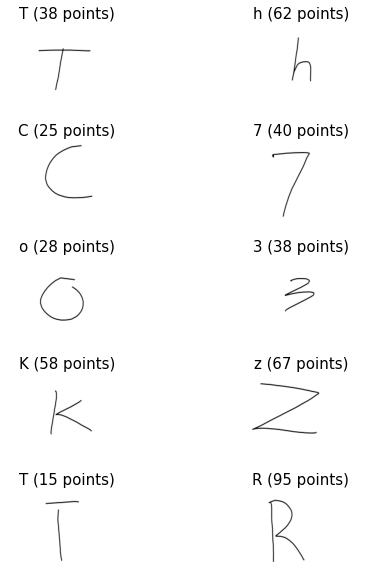

In [6]:
NUM_SAMPLES = 10
display_samples_from_files(
    NUM_SAMPLES,
    all_data,
)